In [1]:
import sys, os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../modules/'))
import healpy as h
from flat_sky_codes import flat_sky_analysis as fsa
from masking import gen_masks as gm
from astropy.io import fits
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


# Tests on simulations

In [30]:
npix=512
reso=1.5

def return_center_mask(radius=50.):
	mask=np.zeros((npix,npix),float)
	distance=np.zeros((npix,npix),float)
	y,x=np.indices((distance.shape))
	xc=np.int(npix/2) ; yc=xc
	distance=np.sqrt((x-xc)**2. +(y-yc)**2.)*reso
	maxnpix=2*int(radius/reso)
	cpix=int(npix/2.)
	mask[distance<=radius]=1.
	return mask

def return_edge_apodized_mask(edge_width=17.,fwhm=20.):
	mask=np.ones((npix,npix),float)
	epix=np.int(np.ceil(edge_width/reso))
	mask[:epix,:]=0 ; mask[npix-epix:,:]=0
	mask[:,:epix]=0 ; mask[:,npix-epix:]=0
	ell,bl=fsa.get_gauss_beam(fwhm,20000)
	mask=fsa.filter_map(mask,reso,bl,ell)
	return mask

def return_ps_filled_data(data,mask,pixel_size,diffthr=1e-4,itermax=20):
    npix=data.shape[0]
    
    ellstep=arange(500,6500,500)
    bl=np.ones(6000,float) ; elld=arange(np.size(bl))
    
    fdata=np.zeros_like(data)
    for lmax in ellstep:
        bl=np.ones(6000,float)
        bl[elld>lmax]=0.
        lpfiltr=fsa.get_fourier_filter(cl=bl,ell=elld,nxpix=npix,pixel_size=pixel_size)
        imp=1. ; diff=1. ; iterations=0
        while diff>diffthr and iterations<itermax:
            ofdata=data+fdata*(1-mask)
            fdatalm=fsa.map2alm(ofdata,pixel_size=pixel_size)
            fdata=fsa.alm2map(fdatalm*lpfiltr,pixel_size=pixel_size)
            temp=np.sum(((fdata-ofdata).ravel())**2.)
            diff = abs(imp-temp)/imp
            imp=temp
            iterations=iterations+1
            print lmax,iterations,diff
    return fdata

<IPython.core.display.Javascript object>


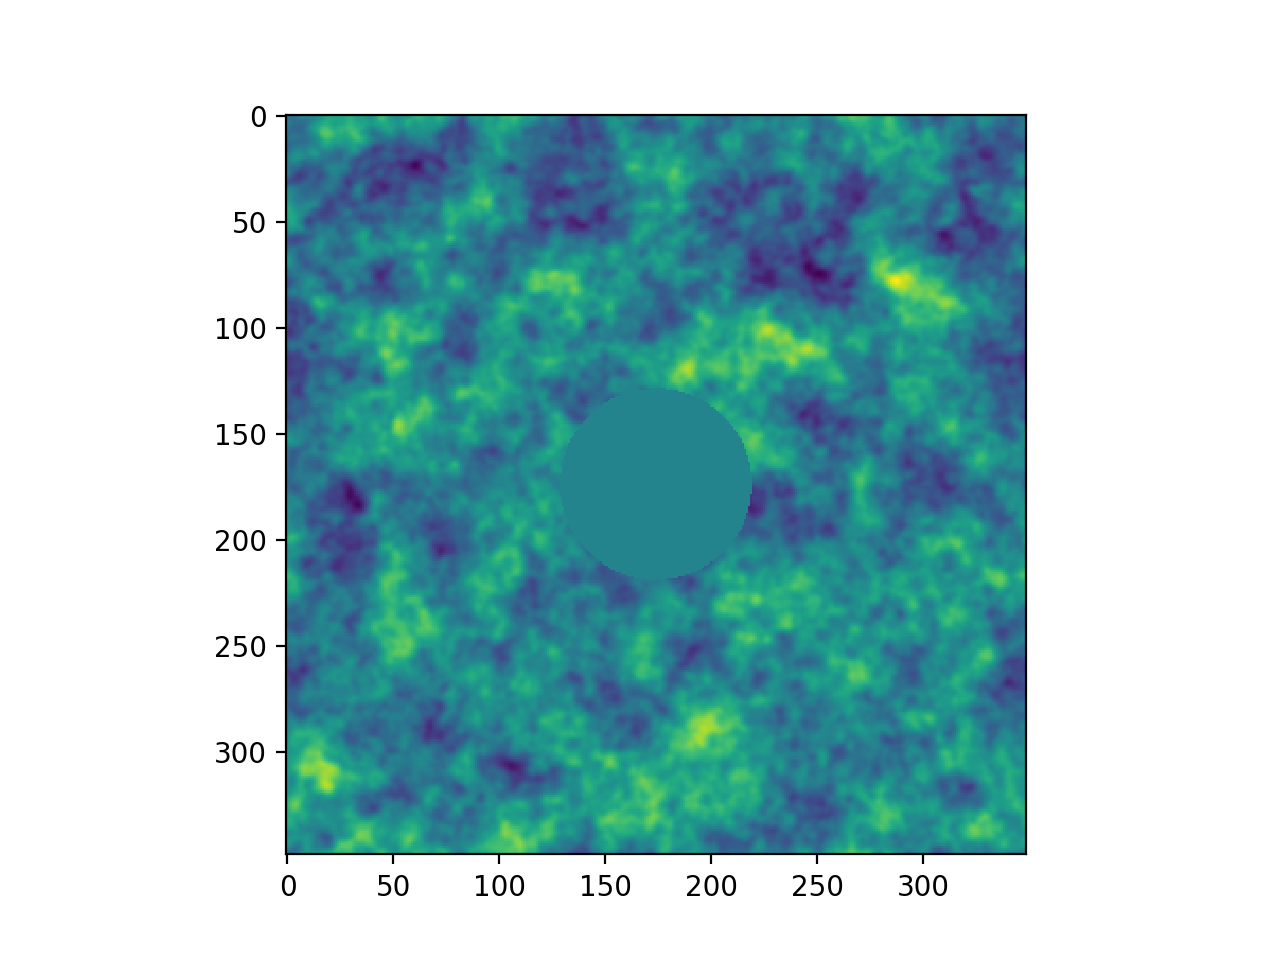

In [80]:
cl=h.read_cl("../../../../../../Data/Planck/spectra/planck_wp_highL_lensing_param.fits")[0]
ell=arange(np.size(cl))
mask=1.-return_center_mask(radius=80)
data=fsa.gensim(cl,npix,reso)*mask
figure()
imshow(data)

In [81]:
fdata=return_ps_filled_data(data,mask,reso)

<IPython.core.display.Javascript object>


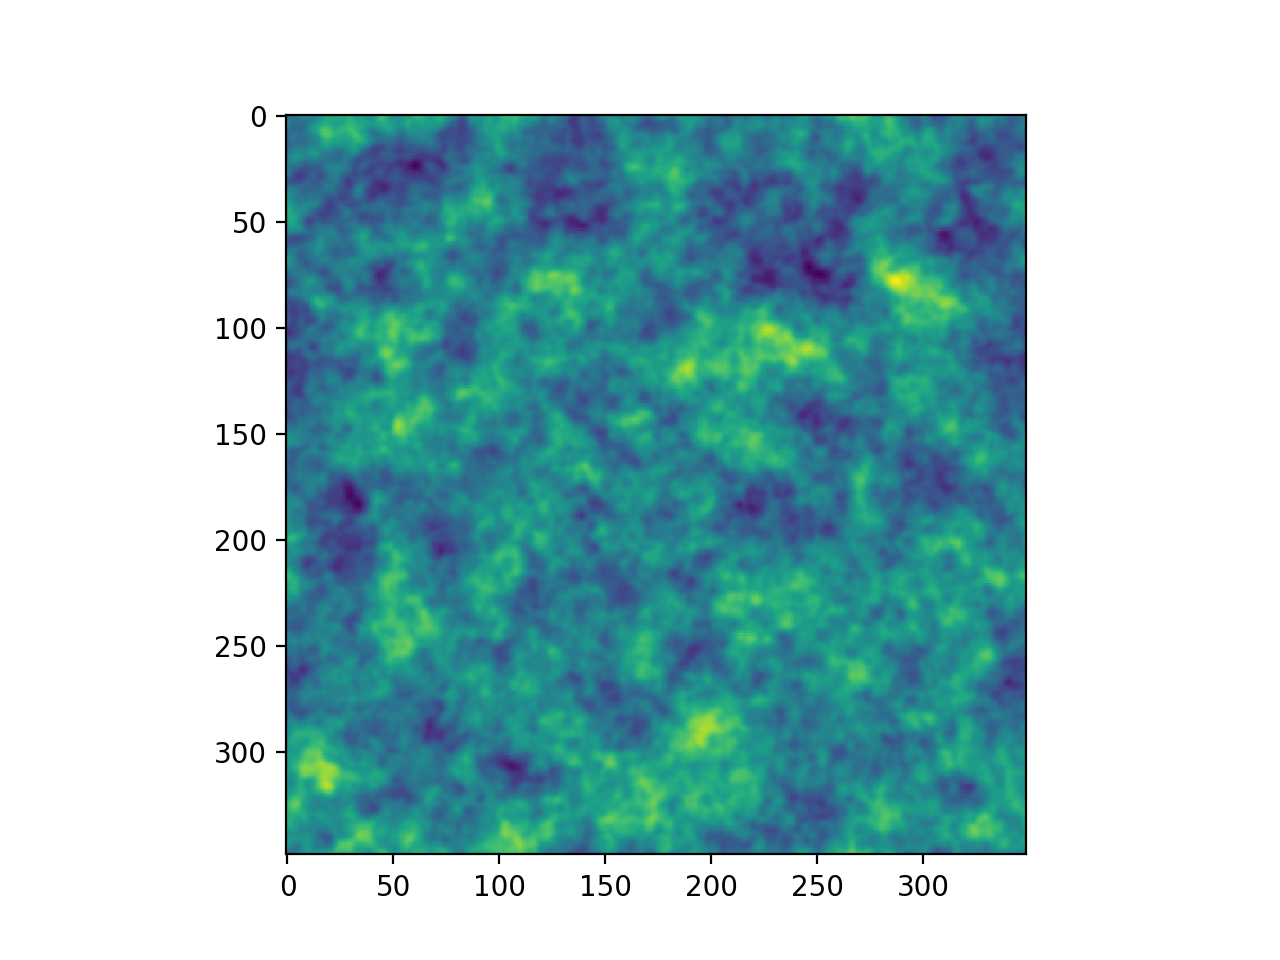

<IPython.core.display.Javascript object>


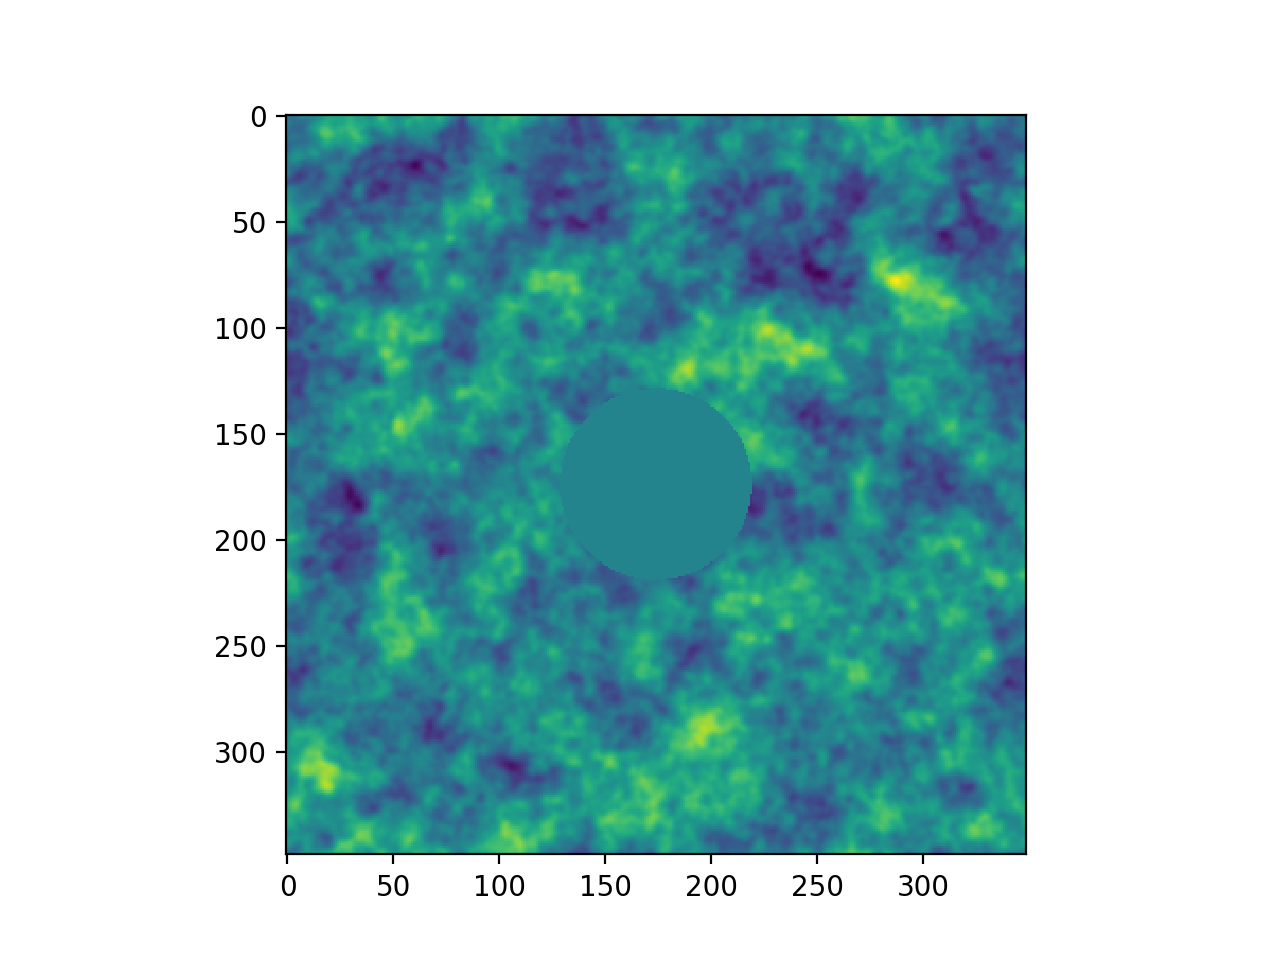

In [82]:
figure()
imshow(fdata)

figure()
imshow(data)

# Testing on data

<IPython.core.display.Javascript object>


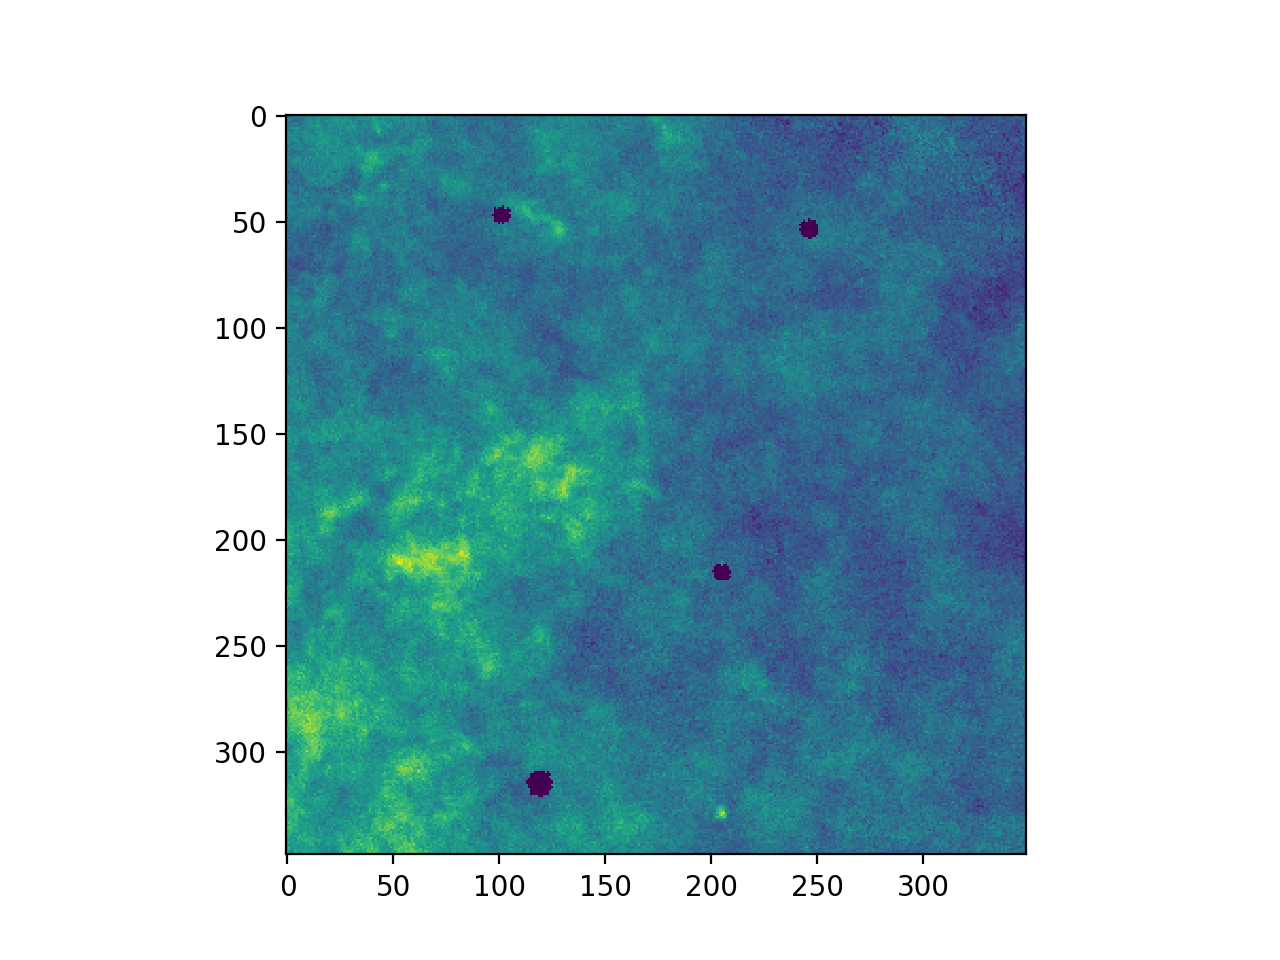

In [74]:
filename="../../tempdata/planck_pr3/planck_cosmo_cat/10deg_patches/tangent_planes/cluster_G241.79-24.01.fits"
f1=fits.open(filename)
data=f1[2].data[6,]
mask=f1[3].data
data=data*mask

npix=data.shape[0]
reso=1.77
datalm=fsa.map2alm(data,pixel_size=reso)

figure()
imshow(data)

In [84]:
data=fits.getdata(filename,ext=2)

In [86]:
data.shape[0]

9

In [75]:
fdata=return_ps_filled_data(data,mask,reso,diffthr=1e-3)
#fdata1=return_ps_filled_data(data,mask,reso,diffthr=1e-4)

<IPython.core.display.Javascript object>


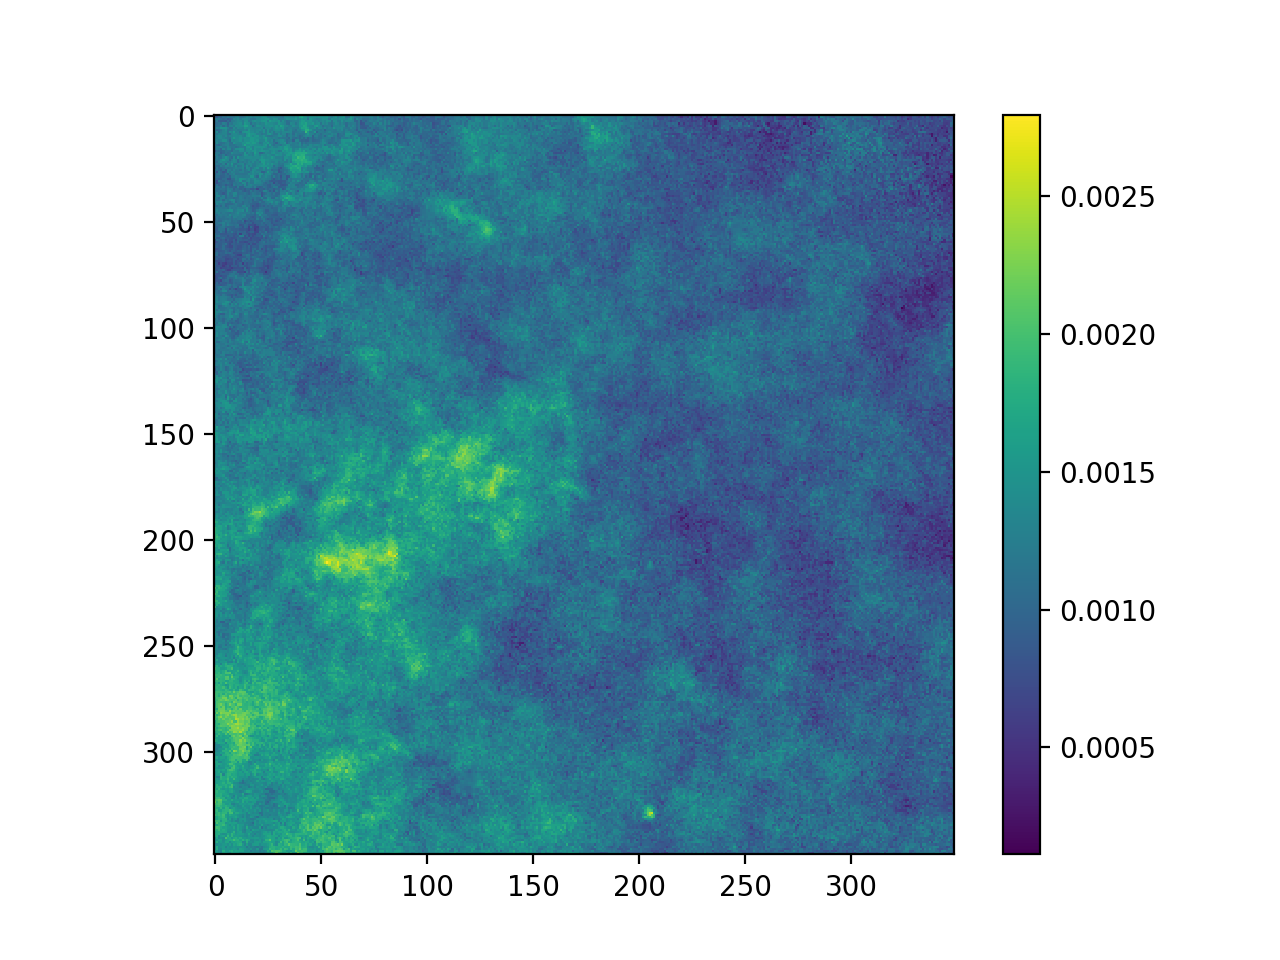

<IPython.core.display.Javascript object>


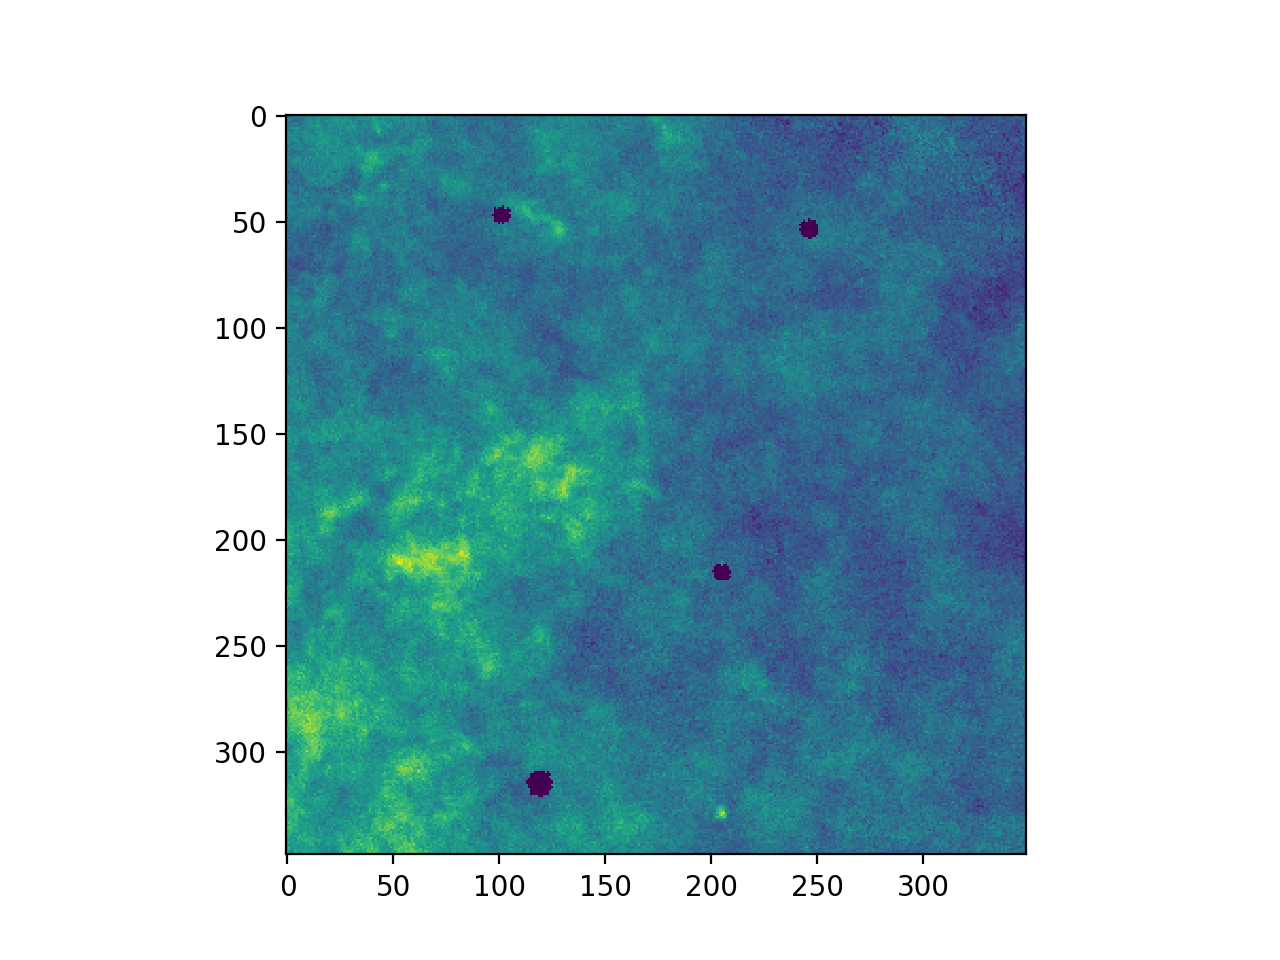

In [76]:
figure()
imshow(fdata)
colorbar()

figure()
imshow(data)

<IPython.core.display.Javascript object>


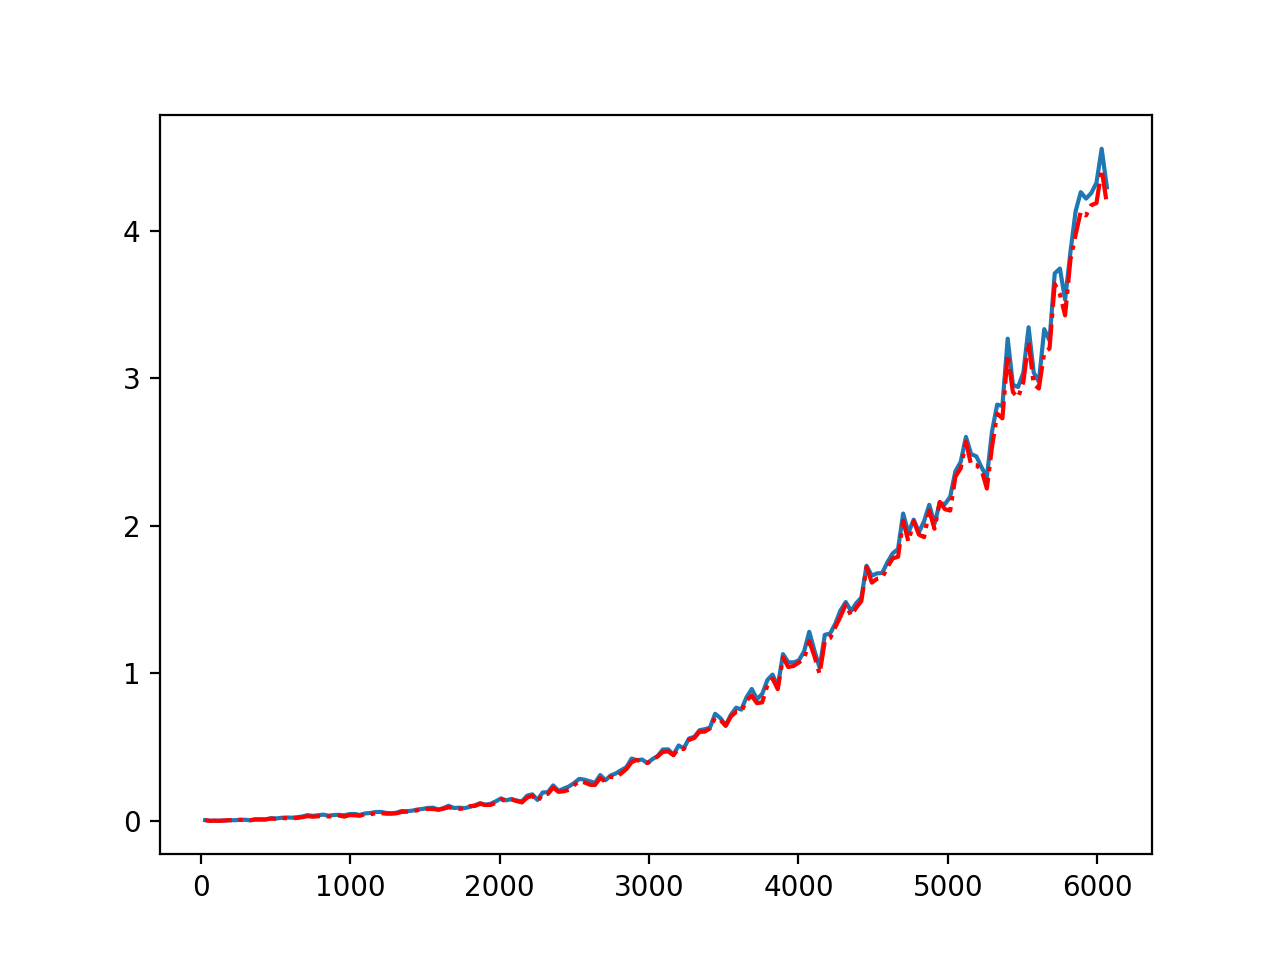

In [77]:
elld,clfdata=fsa.map2cl(fdata,pixel_size=reso)
elld,cldata=fsa.map2cl(data,pixel_size=reso)

figure()
plot(elld,elld**4*cldata)
plot(elld,elld**4*clfdata,"r-.")
#loglog()